In [1]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627558 sha256=d722add5eb1c72c986932302fc7c0869cfc3844b1871c44edb896740d52c629a
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.8-py2.py3-none-any.whl size=60725 sha256=ceb7ccf3887dab38b26b6cb6492f488352eceb97d9aa2b34a165b56e71252650
  Stored in directory: /root/.cache/pip/wheels/bd/2d/ef/0127a17bafa44971f11d05d0e38d7947144cf9e33313bf12a7
Successfully built pycuda pytools


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['hist', 'mod', 'histogram']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


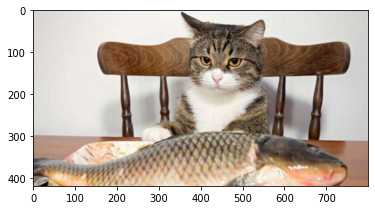

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


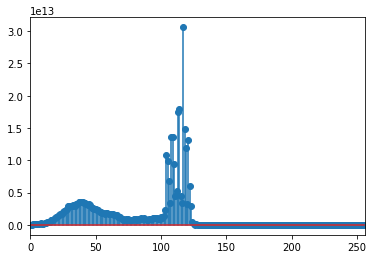

In [19]:
import pycuda.autoinit
import pycuda.driver as cuda
import numpy
import matplotlib.pyplot as plt
from pycuda.compiler import SourceModule
from PIL import Image

mod = SourceModule("""
                   
__global__ void histogram(int *d_b, int *d_a, int SIZE)
{
    int tid = threadIdx.x + blockDim.x * blockIdx.x;
	int item = d_a[tid];
	if (tid < SIZE)
	{
		atomicAdd(&(d_b[item]), 1);
	}
}
""")

image = Image.open("image.jpg")
width, height = image.size
histogram = mod.get_function("histogram")
import cv2
h_img = cv2.imread("image.jpg",0)
h_a=h_img.flatten()
h_a=h_a.astype(numpy.int)
h_result = numpy.zeros(256).astype(numpy.int)
SIZE = h_img.size
NUM_BIN=256
n_threads= int(numpy.ceil((SIZE+NUM_BIN-1) / NUM_BIN))

histogram(
        cuda.Out(h_result), cuda.In(h_a), numpy.uint32(SIZE),
        block=(width,1,1), grid=(height,1,1))

%pylab inline
import matplotlib.image as mpimg
img = mpimg.imread("image.jpg")
imgplot = plt.imshow(img)
plt.show()


plt.stem(h_result)
plt.xlim([0,256])
start = cv2.getTickCount()
hist = cv2.calcHist([h_img],[0],None,[256],[0,256])
